In [2]:
import numpy as np
import math 
import pandas as pd
from pandas.io.json import json_normalize
import json
import sys  
sys.path.insert(0, './scripts')
from PricingModels import *


trades = []
run_matrix=[]
cols = ["init.apy","init.percent_fee","init.days_until_maturity","init.max_order_size","init.time_stretch",\
        "init.market_price","init.target_liquidity","init.target_daily_volume","input.day","input.time",\
        "input.base_market_price", "input.unit_fyt_price","input.base_reserves","input.fyt_reserves",\
        "input.token_in","input.amount_specified","input.token_out","input.direction",\
        "output.trade_volume","output.fee","output.slippage"]

ybas = [
    {
        "vault" : "ySTETH",
        "apy" : 10,
        "market_price" : 2000,
        "time_stretch": 8,
        "days_until_maturity": 90,
    },
]


for target_daily_volume in [5000000,10000000]:
    for target_liquidity in [10000000]:
        for g in [.1]:
                for yba in ybas:
                    np.random.seed(2)
                    APY=yba["apy"]
                    days_until_maturity = yba["days_until_maturity"]
                    market_price = yba["market_price"]
                    time_stretch = yba["time_stretch"]
                    run_matrix.append((yba,g,target_liquidity,target_daily_volume))

                    y_start = target_liquidity/market_price
                    max_order_price=12500
                    max_order_size=max_order_price/market_price 
                    sigma=max_order_size/10
                    liquidity = 0
                    
                    # dirty hack to ensure that we dont overshoot the target liquidity
                    while True:
                        x_start = Element_Pricing_Model.calc_x_reserves(APY,y_start,days_until_maturity,time_stretch)
                        total_supply=x_start
                        t=days_until_maturity/(365*time_stretch)
                        liquidity=x_start*market_price+y_start*market_price*Element_Pricing_Model.fyt_price(x_start,y_start,total_supply,t)
                        if liquidity > target_liquidity:
                            y_start-=10
                        else:
                            break
                    
                    step_size=t/days_until_maturity
                    epsilon=step_size/2
                    m = Market(x_start,y_start,g,t,total_supply,Element_Pricing_Model)
                    print("Days Until Maturity: " + str(days_until_maturity))
                    print("Time Stretch: " + str(time_stretch))
                    print("Fee %: " + str(g*100))
                    print("Max order size: " + str(max_order_size))
                    print("Starting APY: {:.2f}%".format(m.apy(days_until_maturity)))
                    print("Starting FYT Price: " + str(m.fyt_price()))
                    print("Starting Liquidity: ${:,.2f}".format(liquidity))
                    print("Starting Base Reserves: " + str(m.x))
                    print("Starting FYT Reserves: " + str(m.y))
                    x_orders=0
                    x_volume=0
                    y_orders=0
                    y_volume=0

                    total_fees = 0
                    todays_volume = 0
                    todays_fees = 0
                    todays_num_trades = 0
                    day=0
                    while m.t > epsilon:
                        day += 1
                        todays_volume = 0
                        todays_fees = 0
                        todays_num_trades = 0
                        maturity_ratio = day/days_until_maturity
                        ub=target_daily_volume*math.log10(1/maturity_ratio) # log(1/maturity ratio) is used to simulate waning demand over the lifetime of the fyt
                        todays_target_volume = np.random.uniform(ub/2,ub)
                        while todays_target_volume > todays_volume:
                            fee = -1
                            trade = []
                            while fee < 0:
                                # determine order size
                                amount = np.random.normal(max_order_size/2,sigma)
                                lb_amount = max(0.00001,amount)
                                amount = min(max_order_size,lb_amount)
                                # buy fyt or base
                                if np.random.uniform(0,1) < 0.5:
                                    token_in = "base"
                                    token_out = "fyt"
                                else:
                                    token_in = "fyt"
                                    token_out = "base"

                                if np.random.uniform(0,1) < 0.5:
                                    direction="in"
                                else:
                                    direction="out"
                                    

                                start_x_volume = m.x_volume
                                start_y_volume = m.y_volume
                                (without_fee_or_slippage,with_fee,without_fee,fee) = m.swap(amount,direction,token_in,token_out)
                                
                                trade = [APY,g,days_until_maturity,max_order_size,time_stretch,market_price,target_liquidity,target_daily_volume,day,m.t,market_price,m.fyt_price(),m.x,m.y,token_in,amount,token_out,direction,with_fee*market_price,fee*market_price,(without_fee_or_slippage-without_fee)*market_price]
                                
                            trades.append(trade);
                            todays_volume += (m.x_volume - start_x_volume)*market_price + (m.y_volume - start_y_volume)*market_price
                            todays_fees += fee*market_price
                            todays_num_trades += 1
                        print("\tDay: " + str(day) + " FYT Price: " + str(m.fyt_price()) + " Implied APY: " + str(m.apy(days_until_maturity-day+1)) + " Target Volume Factor: {:,.4f}".format(math.log10(1/maturity_ratio)) + " Volume: ${:,.2f}".format(todays_volume) + " Num Trades: " + str(todays_num_trades) + " Fees: ${:,.2f}".format(todays_fees))
                        total_fees += todays_fees
                        m.tick(step_size)

                    print("Ending Liquidity: ${:,.2f}".format(m.x*market_price+m.y*market_price*m.fyt_price()))
                    print("Total volume: ${:,.2f}".format(m.x_volume*market_price+m.y_volume*market_price))
                    print("Total fees: ${:,.2f}".format(total_fees))
                    print("Ending Base Reserves: " + str(m.x))
                    print("Delta Base Reserves: " + str(abs(x_start-m.x)))
                    print("Ending FYT Reserves: " + str(m.y))
                    print("Delta FYT Reserves: " + str(abs(y_start-m.y)))
                    print("Num base orders: " + str(m.x_orders))
                    print("Cum base volume: " + str(m.x_volume))
                    print("Num FYT orders: " + str(m.y_orders))
                    print("Cum FYT volume: " + str(m.y_volume))
                    print("Cum slippage Base: " + str(m.cum_x_slippage))
                    print("Cum slippage FYT: " + str(m.cum_y_slippage))
                    print("Cum fees Base: " + str(m.cum_x_fees))
                    print("Cum fees FYT: " + str(m.cum_y_fees))
                    print("Ending FYT Price: " + str(m.fyt_price()))
                    print("Ending Time: " + str(m.t))
                    print("##################################################################")



#df = pd.DataFrame.from_dict(json_normalize(trades), orient='columns')
df = pd.DataFrame(trades,columns=cols)




Days Until Maturity: 90
Time Stretch: 8
Fee %: 10.0
Max order size: 6.25
Starting APY: 10.00%
Starting FYT Price: 0.9753424657534245
Starting Liquidity: $9,984,733.03
Starting Base Reserves: 2251.6541863586
Starting FYT Reserves: 2810.0
	Day: 1 FYT Price: 0.9725701036966566 Implied APY: 11.124346834133696 Target Volume Factor: 1.9542 Volume: $7,016,289.06 Num Trades: 1132 Fees: $18,159.60
	Day: 2 FYT Price: 0.9758367106324967 Implied APY: 9.909663617009796 Target Volume Factor: 1.6532 Volume: $6,739,150.52 Num Trades: 1081 Fees: $17,368.82
	Day: 3 FYT Price: 0.9761762118399651 Implied APY: 9.881457589105402 Target Volume Factor: 1.4771 Volume: $6,493,448.39 Num Trades: 1041 Fees: $15,392.98
	Day: 4 FYT Price: 0.97415107941602 Implied APY: 10.844662084083575 Target Volume Factor: 1.3522 Volume: $4,390,356.12 Num Trades: 704 Fees: $11,367.61
	Day: 5 FYT Price: 0.9740996982737334 Implied APY: 10.992569918706156 Target Volume Factor: 1.2553 Volume: $5,783,241.16 Num Trades: 927 Fees: $15,0

	Day: 4 FYT Price: 0.972511360293493 Implied APY: 11.532590221695443 Target Volume Factor: 1.3522 Volume: $12,331,588.78 Num Trades: 1973 Fees: $33,973.89
	Day: 5 FYT Price: 0.9694767528786582 Implied APY: 12.954633952662508 Target Volume Factor: 1.2553 Volume: $6,670,965.79 Num Trades: 1063 Fees: $19,822.10
	Day: 6 FYT Price: 0.9710705350268372 Implied APY: 12.422652606122869 Target Volume Factor: 1.1761 Volume: $8,794,937.89 Num Trades: 1415 Fees: $26,611.82
	Day: 7 FYT Price: 0.9704293300102786 Implied APY: 12.849160174105112 Target Volume Factor: 1.1091 Volume: $7,925,179.19 Num Trades: 1272 Fees: $23,479.26
	Day: 8 FYT Price: 0.9701709149404223 Implied APY: 13.117609694874535 Target Volume Factor: 1.0512 Volume: $7,967,780.50 Num Trades: 1267 Fees: $25,352.71
	Day: 9 FYT Price: 0.9745983177256939 Implied APY: 11.306846378197209 Target Volume Factor: 1.0000 Volume: $9,217,474.31 Num Trades: 1468 Fees: $25,093.88
	Day: 10 FYT Price: 0.9776718864922501 Implied APY: 10.061433864603341

	Day: 72 FYT Price: 0.9955647167052163 Implied APY: 8.52041264524239 Target Volume Factor: 0.0969 Volume: $893,364.44 Num Trades: 142 Fees: $395.70
	Day: 73 FYT Price: 0.9957263216998946 Implied APY: 8.666069886324815 Target Volume Factor: 0.0909 Volume: $720,763.52 Num Trades: 111 Fees: $306.19
	Day: 74 FYT Price: 0.9959491774887363 Implied APY: 8.697354215360194 Target Volume Factor: 0.0850 Volume: $690,062.35 Num Trades: 111 Fees: $282.58
	Day: 75 FYT Price: 0.9962338433142941 Implied APY: 8.591544939266587 Target Volume Factor: 0.0792 Volume: $696,169.99 Num Trades: 112 Fees: $263.05
	Day: 76 FYT Price: 0.9966653843484684 Implied APY: 8.114231418726874 Target Volume Factor: 0.0734 Volume: $485,027.84 Num Trades: 81 Fees: $166.50
	Day: 77 FYT Price: 0.9970553890460062 Implied APY: 7.677021415769516 Target Volume Factor: 0.0678 Volume: $518,604.09 Num Trades: 85 Fees: $158.20
	Day: 78 FYT Price: 0.9973549196751003 Implied APY: 7.42657168144927 Target Volume Factor: 0.0621 Volume: $33

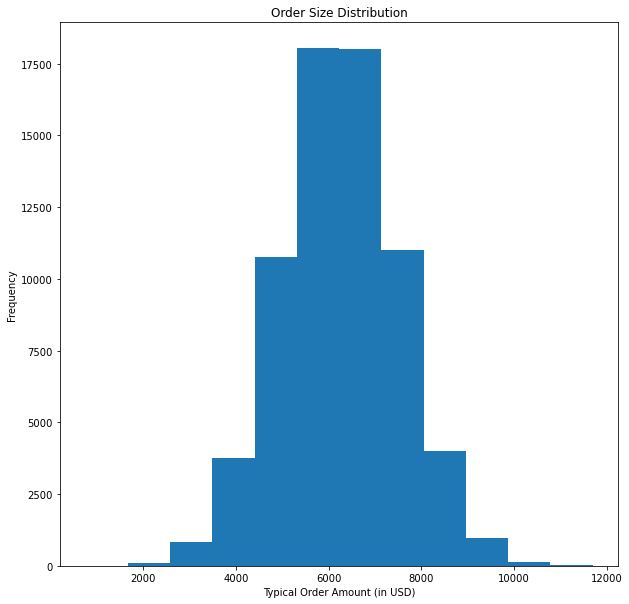

In [3]:
import matplotlib.pyplot as plt

hist=df['output.trade_volume'].plot.hist(bins=12,title="Order Size Distribution",figsize=(10,10));
hist=hist.set_xlabel("Typical Order Amount (in USD)")

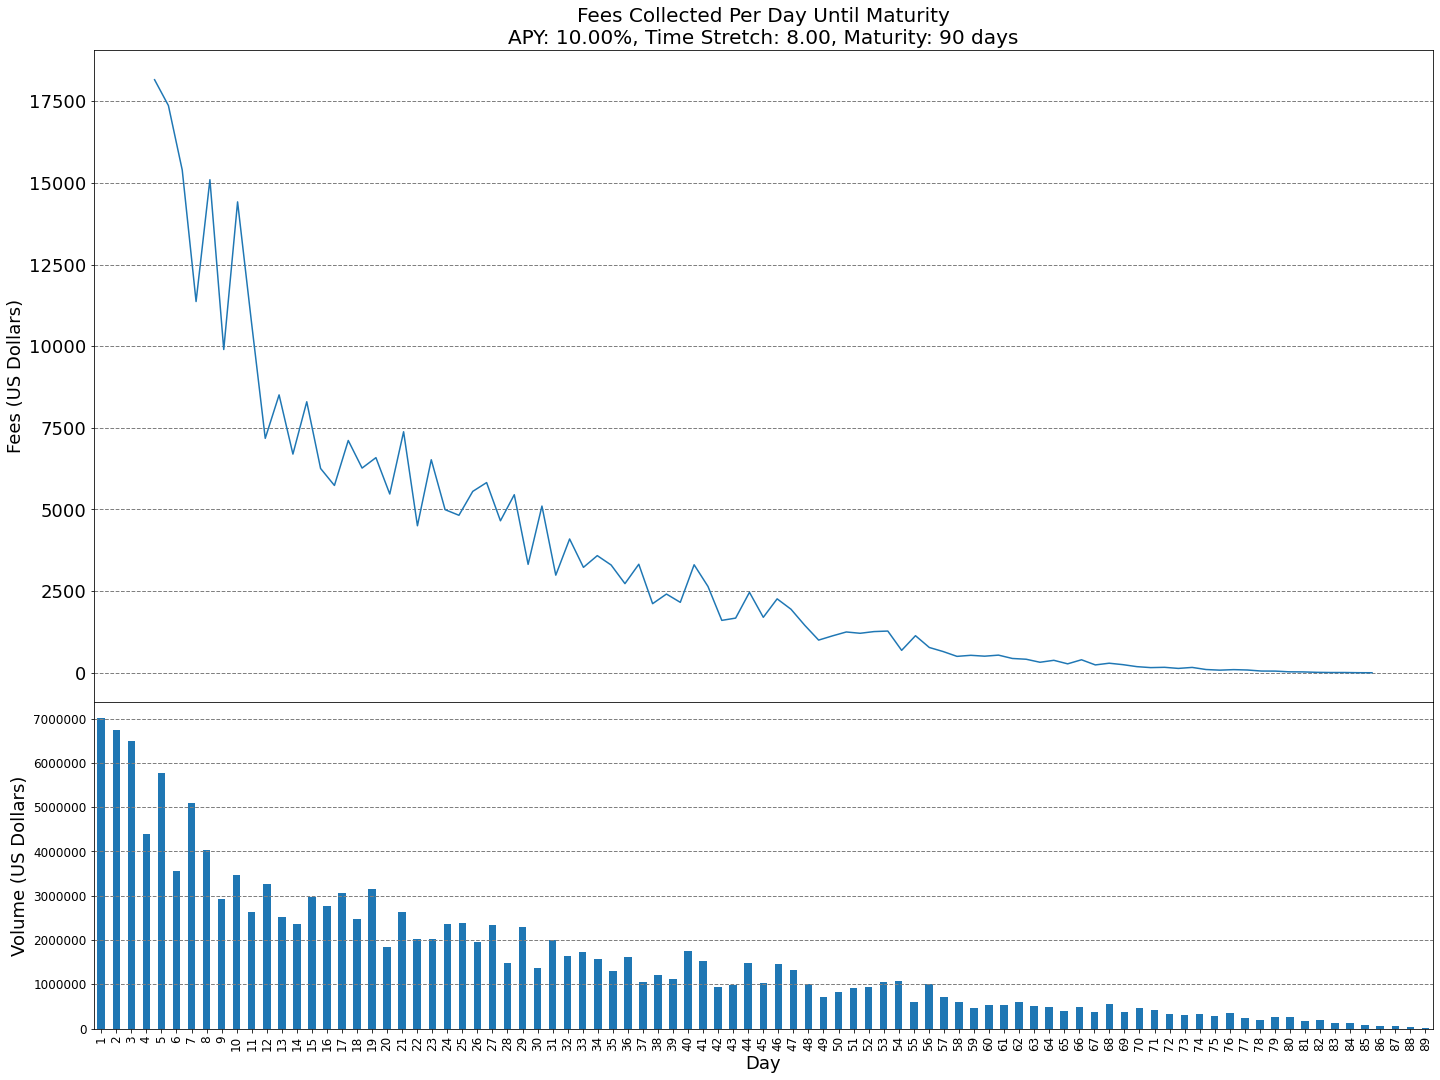

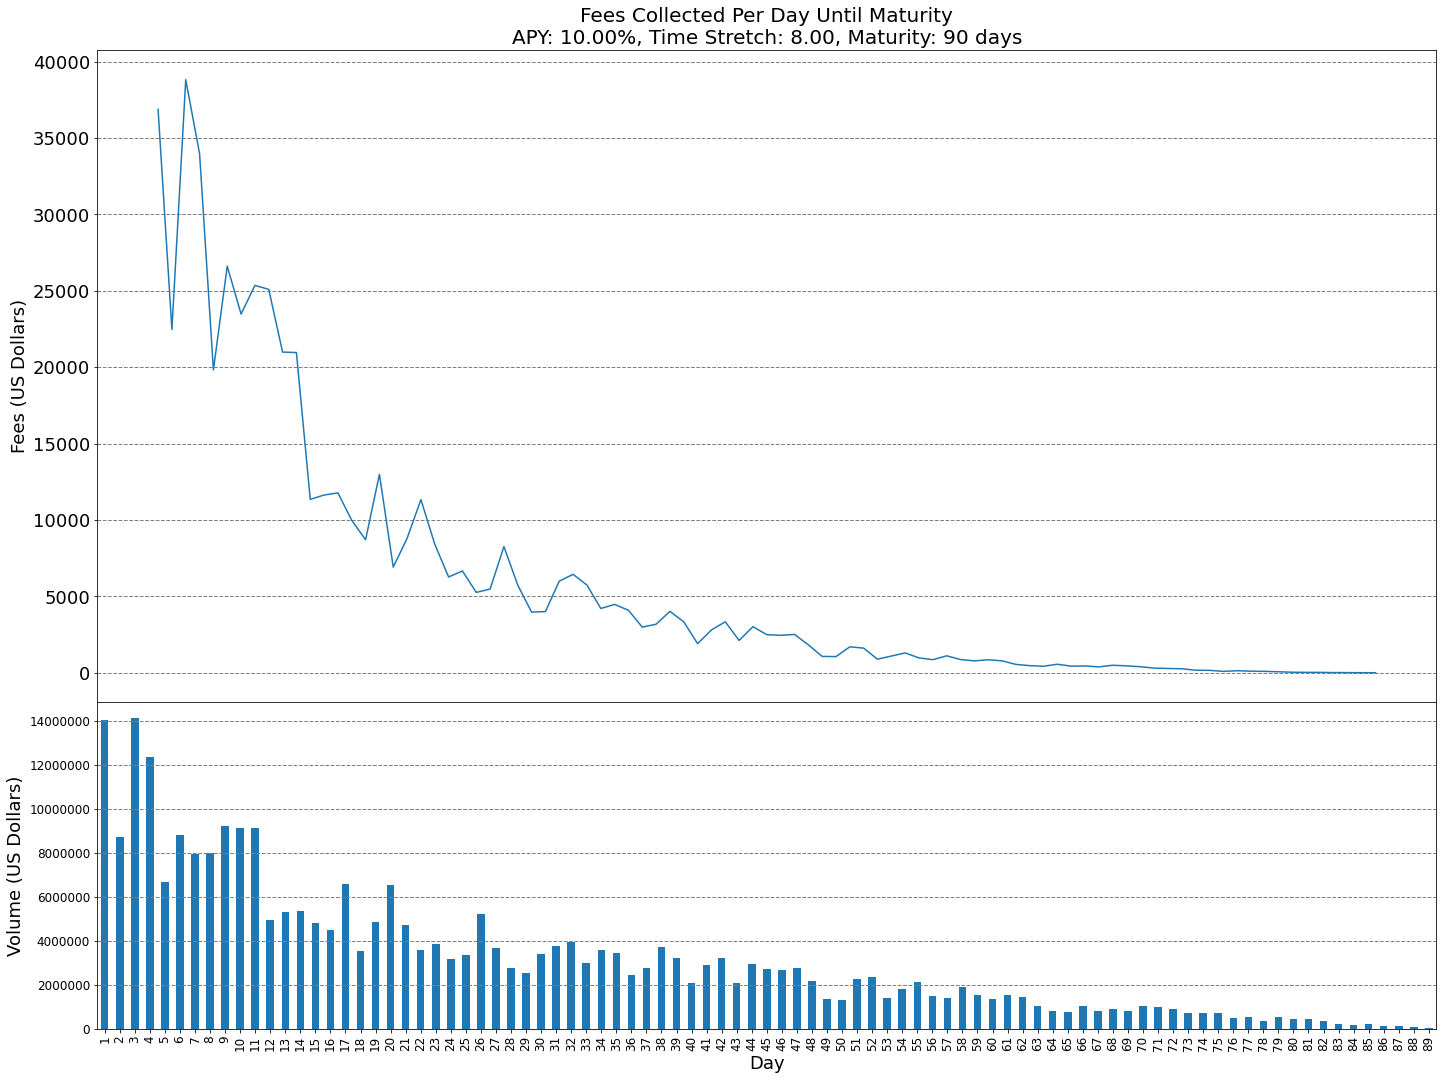

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

dfs=[]
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  dfs.append(df[ (df['init.market_price']==yba["market_price"]) & (df['init.time_stretch']==yba["time_stretch"]) & (df['init.apy']==yba["apy"]) & (df['init.percent_fee']==g) & (df['init.days_until_maturity']==yba["days_until_maturity"]) & (df['init.target_liquidity']==target_liquidity) & (df['init.target_daily_volume']==target_daily_volume)].reset_index())

for _df in dfs:
    fig, ax = plt.subplots(ncols=1, nrows=2,gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[2,1]})
    df_fees_volume = _df.groupby(['input.day']).agg({'output.trade_volume':['sum']\
                                   ,'output.fee':['mean','std','min','max','sum']\
                                  })
    df_fees_volume.columns = ['_'.join(col).strip() for col in df_fees_volume.columns.values]
    df_fees_volume = df_fees_volume.reset_index()
    ax[0] = df_fees_volume.plot(x="input.day", y="output.fee_sum",figsize=(24,18),ax=ax[0]);
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Fees (US Dollars)",fontsize=18)
    ax[0].tick_params(axis = "both", labelsize=18)
    ax[0].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[0].xaxis.set_ticklabels([])
    title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Time Stretch: {:.2f}, Maturity: {:} days".format(_df['init.apy'][0],_df['init.time_stretch'][0],_df['init.days_until_maturity'][0])
    ax[0].set_title(title,fontsize=20)
    ax[0].legend().set_visible(False)

    ax[1] = df_fees_volume.plot(kind='bar',x="input.day", y="output.trade_volume_sum",ax=ax[1]);
    ax[1].set_xlabel("Day",fontsize=18)
    ax[1].set_ylabel("Volume (US Dollars)",fontsize=18)
    ax[1].tick_params(axis = "both", labelsize=12)
    ax[1].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[1].legend().set_visible(False)
    ax[1].ticklabel_format(style='plain',axis='y')
    fig.subplots_adjust(wspace=None, hspace=None)

In [5]:
df_fees_volume

,input.day,output.trade_volume_sum,output.fee_mean,output.fee_std,output.fee_min,output.fee_max,output.fee_sum
0,1,1.403385e+07,16.421166,3.334992,5.868997,27.786701,36881.938539
1,2,8.693863e+06,16.003551,3.259048,5.934215,28.378837,22468.985165
2,3,1.412355e+07,17.205220,3.495904,4.898179,29.895480,38814.976689
3,4,1.233159e+07,17.219405,3.508169,5.045219,29.058482,33973.886926
4,5,6.670966e+06,18.647324,3.770581,7.653708,29.748161,19822.104886
...,...,...,...,...,...,...,...
84,85,1.979768e+05,0.816710,0.161947,0.494534,1.117986,25.317999
85,86,1.110390e+05,0.700332,0.178740,0.395594,1.114956,11.905637
86,87,1.267294e+05,0.491802,0.086758,0.261628,0.723066,10.819641
87,88,6.630457e+04,0.376048,0.073944,0.286700,0.483231,4.136528


In [6]:
pd.options.display.float_format = '{:,.8f}'.format
df_fees_agg = df.groupby(['init.apy','init.percent_fee','init.time_stretch','init.market_price','init.target_liquidity','init.days_until_maturity','init.target_daily_volume']).agg({'output.fee':['count','sum'],'output.trade_volume':['sum'],'output.slippage':['mean'],'input.amount_specified':['mean']})
df_fees_agg.columns = ['_'.join(col).strip() for col in df_fees_agg.columns.values]
df_fees_agg = df_fees_agg.reset_index()
df_fees_agg['init.percent_fee'] = df_fees_agg['init.percent_fee'].round(2)
df_fees_agg['output.mean_daily_volume'] = df_fees_agg['output.trade_volume_sum']/df_fees_agg['init.days_until_maturity']
df_fees_agg['output.apr'] = (df_fees_agg['output.fee_sum']/df_fees_agg['init.target_liquidity']) * (365/df_fees_agg['init.days_until_maturity'])*100
df_fees_agg = df_fees_agg.drop(columns=['input.amount_specified_mean']).reset_index()
df_fees_agg

,index,init.apy,init.percent_fee,init.time_stretch,init.market_price,init.target_liquidity,init.days_until_maturity,init.target_daily_volume,output.fee_count,output.fee_sum,output.trade_volume_sum,output.slippage_mean,output.mean_daily_volume,output.apr
0,0,10,0.10000000,8,2000,10000000,90,5000000,22423,"304,541.91026903","140,244,263.80262518",-0.00002811,"1,558,269.59780695",12.35086636
1,1,10,0.10000000,8,2000,10000000,90,10000000,45188,"530,215.82986448","282,196,103.62459433",0.00004058,"3,135,512.26249549",21.50319754


In [7]:
#df_fees_agg.to_csv("fees.csv")
#print(df_fees_agg[['init.target_liquidity','init.target_daily_volume','output.fee_sum','output.trade_volume_sum','output.mean_daily_volume','output.apr']].to_markdown(index=False))

print(df_fees_agg[['init.target_liquidity','output.trade_volume_sum','output.mean_daily_volume','output.apr']].to_markdown(index=False,floatfmt=(",.0f", ",.0f",",.0f",",.2f")))

|   init.target_liquidity |   output.trade_volume_sum |   output.mean_daily_volume |   output.apr |
|------------------------:|--------------------------:|---------------------------:|-------------:|
|              10,000,000 |               140,244,264 |                  1,558,270 |        12.35 |
|              10,000,000 |               282,196,104 |                  3,135,512 |        21.50 |


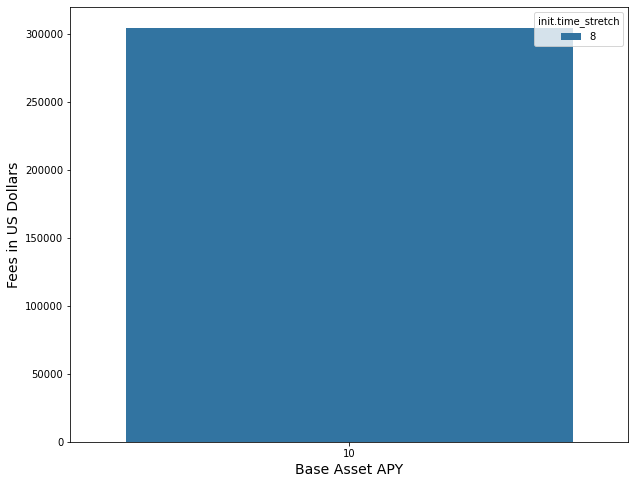

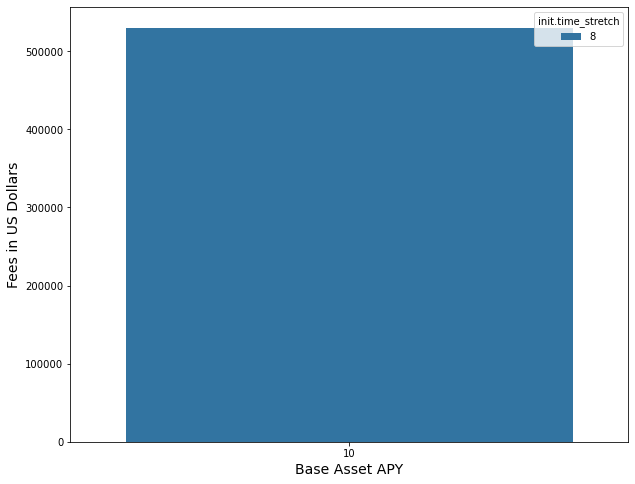

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

#plt.figure(figsize=(20, 20))
#for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
#condition = (df_fees_agg['init.market_price']==yba["market_price"]) & (df_fees_agg['init.days_until_maturity']==yba["days_until_maturity"]) & (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  plt.figure(figsize=(10, 8))
  condition =   (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
  sns.barplot(x="init.apy", 
              y="output.fee_sum", 
              hue="init.time_stretch", 
              data=df_fees_agg[condition],
              ci=None)
  plt.ticklabel_format(style='plain',axis='y')
  plt.ylabel("Fees in US Dollars", size=14)
  plt.xlabel("Base Asset APY", size=14)
  #title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
  #plt.title("Cumulative Fees for 30 day FYT\n"+"Target Volume = " + str(df_fees_agg[condition]['init.target_daily_volume'].iloc[0]) + "\nTarget Liquidity = " + str(df_fees_agg[condition]['init.target_liquidity'].iloc[0]), size=14)
